In [1]:
from scipy.io import loadmat

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colorbar as mbar
import seaborn as sns

from scipy.ndimage import gaussian_filter as smooth

from scipy.stats import permutation_test
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

# Definitions

In [2]:
def m_plot(input_data, colors, error_method='sem', smooth_win=0, labels=[], plot_title='', timepoints=[], figure_size=(8,3)):
    '''
    Args:
        input_data:   (N,M,T) matrix of input data, (Conditions,Samples,Timepoints)
        colors:       (N,4) matrix of colors for the generated plots in [R,G,B,FaceAlpha] format,
                      where N is the number of conditions. FaceAlpha in the scale=[0-255]
        error_method: variation metric ('sem' & 'std')
        smooth_win:   smoothing window
        
        labels:       (N,) list of labels for the generated plots, where N is the number of conditions
        plot_title:   title of the generated plot
        timepoints:   (N,) vaetor of timepoints
        figure_size:  two-item tuple containing width and height of the figure
    Returns:
        none
    '''

    colors = np.array(colors) / np.array(255)
    if not labels: labels=['']*len(input_data)
    timepoints = np.array(timepoints)
    if timepoints.size==0: timepoints = np.arange(0,input_data[0].shape[1])
    
    plt.figure(figsize=figure_size)
    # sns.set_style('darkgrid')
    for i,Cond in enumerate(input_data):
        data_ave = smooth(np.nanmean(Cond, axis=0), smooth_win, axes=0)
        data_std = smooth(np.nanstd(Cond, axis=0), smooth_win, axes=0)
        
        if error_method=='sem':
            error_up  = data_ave + (data_std / np.sqrt(Cond.shape[0]))
            error_low = data_ave - (data_std / np.sqrt(Cond.shape[0]))
        elif error_method=='std':
            error_up  = data_ave + data_std
            error_low = data_ave - data_std

        plt.fill_between(timepoints, error_up, error_low, color=colors[i], label='_nolegend_')
        plt.plot(timepoints, data_ave, color=colors[i,:3], lw=3, label=labels[i])
    
    ylim = plt.ylim()
    plt.fill_between([0, 80], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='gray', alpha=.2, edgecolor=None)
    plt.legend(frameon=False, fontsize=10)
    plt.title(plot_title)
    plt.tight_layout()


def FindResp(input_data, time_points, base_time_idx, resp_win=[50,300], onset_method=1):
    '''
    Args:
        input_data:    (N,M) matrix of input data (Trials or Neurons or Repetitions, Timepoints)
        time_points:   (M,) vector for values of the time axis
        base_time_idx: indices corresponding to the baseline
        resp_win:      two-item list of acceptable time window of response, in ms, with respect to time_points
        onset_method:  method to calculate onset
    Returns:
        val_peak:   value of the peak response
        time_peak:  time of the peak response
        time_onset: time of the onset response
        time_sol:   solution time, i.e., difference of peak and onset times (peak time - onset time)
        nan_count:  list containing number of nans for peak and onset times [number onset nans, number of peak nans]
    '''
    
    thr_std_base = 3
    thr_peak = .2

    val_peak, time_peak, time_onset = [], [], []
    for i,rep in enumerate(input_data):
        tmp_time_peak = time_points[rep.argmax()]

        tmp_base_ave = np.nanmean(rep[base_time_idx])
        tmp_base_std = np.nanstd(rep[base_time_idx])
        bools = rep > tmp_base_ave + (thr_std_base*tmp_base_std)
        if bools.sum()>0: tmp_time_onset = time_points[bools][0]
        else: tmp_time_onset = np.nan

        if (tmp_time_peak>resp_win[0]) & (tmp_time_peak<resp_win[1]) & (tmp_time_onset>resp_win[0]) & (tmp_time_onset<resp_win[1]):
            val_peak.append(rep.max())
            time_peak.append(time_points[rep.argmax()])
            time_onset.append(time_points[bools][0])
        else:
            val_peak.append(np.nan)
            time_peak.append(np.nan)
            time_onset.append(np.nan)

    time_sol = np.array(time_peak) - np.array(time_onset)
    nan_count = [(np.isnan(time_peak)).sum(), (np.isnan(time_onset)).sum()]

    return np.array(val_peak), np.array(time_peak), np.array(time_onset), time_sol, nan_count


def comp_permute_p(vec1, vec2, permute_reps=100001):
    '''
    Args:
        vec1:         (N,) vector of data 1st distribution (Samples,)
        vec2:         (N,) vector of data 2nd distribution (Samples,)
        permute_reps: number of repetitions for the permutation process
    Returns:
        p_val: two-tailed p-value of the permutation process for [vec2 - vec1]
    '''

    vec1 = vec1[np.where((~np.isnan(vec1)))[0]]
    vec2 = vec2[np.where((~np.isnan(vec2)))[0]]

    def tmp_test_stat(x, y, axis):
        return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)
    
    p_val = np.nan
    p_val = permutation_test(data=(vec2, vec1), statistic=tmp_test_stat, vectorized=True, axis=0, random_state=15, n_resamples=permute_reps).pvalue

    return p_val


def compare_means_bs(vec1, vec2):
    '''
    Args:
        vec1: (N,) vector of data 1st distribution (Samples,)
        vec2: (N,) vector of data 2nd distribution (Samples,)
    Returns:
        p_val: two-tailed p-value for [vec2 - vec1]
    '''
    
    vec1 = vec1[np.where((~np.isnan(vec1)))[0]]
    vec2 = vec2[np.where((~np.isnan(vec2)))[0]]

    mean_diff = np.mean(vec1) - np.mean(vec2)
    pooled_sd = np.sqrt( (((vec1.shape[0] - 1) * np.var(vec1)) + ((vec2.shape[0] - 1) * np.var(vec2))) / (vec1.shape[0] + vec2.shape[0] - 2) )

    z_val = mean_diff / pooled_sd
    p_val = np.nan
    p_val = 2 * ( 1 -  norm.cdf(abs(z_val)) )

    return p_val



# Load Data


In [ ]:
# load data
FigDir = '../Results/figs_classifier/'

FileDir_anim = '../Data/lda/LDA_v01_Animacy_both.mat'
temp_file_anim = loadmat(FileDir_anim)

FileDir_fb = '../Data/lda/LDA_v01_FaceBody_both.mat'
temp_file_fb = loadmat(FileDir_fb)

lda_fb_itc = temp_file_fb['Result'][0][0][7]
lda_fb_pfc = temp_file_fb['Result'][0][0][8]

lda_anim_itc = temp_file_anim['Result'][0][0][7]
lda_anim_pfc = temp_file_anim['Result'][0][0][8]

# color
color_itc, color_pfc = [255, 187, 112, 80], [129, 104, 157, 80]
color_itc_n, color_pfc_n = np.array(color_itc)/255, np.array(color_pfc)/255
color_anim, color_fb = [198, 60, 81, 80], [82, 34, 88, 80]
color_anim_n, color_fb_n = np.array(color_anim)/255, np.array(color_fb)/255

# parameters
chance_level = 50
time_base = 90 # formerly, it was set to 80

time_stamps = np.arange(lda_fb_itc.shape[1]) - time_base

In [5]:
base_time_idx = (time_stamps>-50) & (time_stamps<50)

_, peak_fb_itc, onset_fb_itc, sol_fb_itc, _ = FindResp(lda_fb_itc, time_stamps, base_time_idx)
_, peak_fb_pfc, onset_fb_pfc, sol_fb_pfc, _ = FindResp(lda_fb_pfc, time_stamps, base_time_idx)

_, peak_anim_itc, onset_anim_itc, sol_anim_itc, _ = FindResp(lda_anim_itc, time_stamps, base_time_idx)
_, peak_anim_pfc, onset_anim_pfc, sol_anim_pfc, _ = FindResp(lda_anim_pfc, time_stamps, base_time_idx)

# ITC

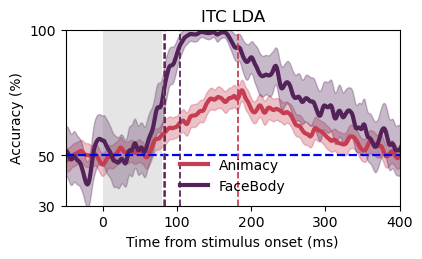

In [9]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [30,100]
figure_size = np.array((4,2.5)) * 1
tmp_region = 'ITC'

m_plot([lda_anim_itc,lda_fb_itc], [color_anim,color_fb], error_method='std', 
       smooth_win=smooth_win, labels=['Animacy','FaceBody'], plot_title=f'{tmp_region} LDA', timepoints=time_stamps, figure_size=figure_size)

plt.axhline(chance_level, ls='--', c='b', lw=figure_size[0]*.4)

plt.axvline(np.nanmedian(onset_anim_itc), ls='--', color=color_anim_n[:3], alpha=1, lw=figure_size[1]*.5)
plt.axvline(np.nanmedian(onset_fb_itc), ls='--', color=color_fb_n[:3], alpha=1, lw=figure_size[1]*.5)

if 1:
       plt.axvline(np.nanmedian(peak_anim_itc), ls='--', color=color_anim_n[:3], alpha=1, lw=figure_size[1]*.5)
       plt.axvline(np.nanmedian(peak_fb_itc), ls='--', color=color_fb_n[:3], alpha=1, lw=figure_size[1]*.5)
else:
       plt.axvline(time_stamps[np.nanmean(lda_anim_itc, axis=0).argmax()], ls='--', color=color_anim_n[:3], alpha=1, lw=figure_size[1]*.5)
       plt.axvline(time_stamps[np.nanmean(lda_fb_itc, axis=0).argmax()], ls='--', color=color_fb_n[:3], alpha=1, lw=figure_size[1]*.5)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel('Accuracy (%)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], chance_level, plot_ylim[1]])

clear_output()
# plt.savefig(f'{FigDir}lda_{tmp_region}_both.svg')

Onset ITC = 83.0 -+ 8.800283360037145
Onset PFC = 82.0 -+ 14.438715817753344
Onset Permutation p = 0.0018999620007599848
Onset p (comp_means) = 0.7303088478899069
-----
Peak ITC = 103.5 -+ 7.617987800595503
Peak PFC = 182.0 -+ 19.404704451539487
Peak Permutation p = 1.999960000799984e-05
Onset p (comp_means) = 1.160677403744259e-06
-----
Solution ITC = 20.5 -+ 11.483147368395787
Solution PFC = 95.0 -+ 25.594679261599794
Solution Permutation p = 1.999960000799984e-05
Onset p (comp_means) = 0.0006299323288967429


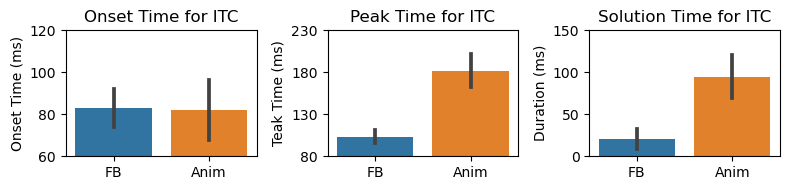

In [25]:
figure_size = np.array((8,2)) * 1
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)
error_method = 'sd'
estimator = 'median'
xtick_labels = ["FB", "Anim"]

plt_onset = sns.barplot(ax=ax[0], data=[onset_fb_itc, onset_anim_itc], estimator='median', errorbar=error_method)
ax[0].set_ylim([60,120])
ax[0].set_yticks([60,80,100,120])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {tmp_region}')
plt_onset.set(xticklabels=xtick_labels)

plt_peak = sns.barplot(ax=ax[1], data=[peak_fb_itc, peak_anim_itc], estimator='median', errorbar=error_method)
ax[1].set_ylim([80,230])
ax[1].set_yticks([80,130,180,230])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {tmp_region}')
plt_peak.set(xticklabels=xtick_labels)

plt_sol = sns.barplot(ax=ax[2], data=[sol_fb_itc, sol_anim_itc], estimator='median', errorbar=error_method)
ax[2].set_ylim([0,150])
ax[2].set_yticks([0,50,100,150])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {tmp_region}')
plt_sol.set(xticklabels=xtick_labels)

plt.tight_layout()

print(f'Onset ITC = {np.nanmedian(onset_fb_itc)} -+ {np.nanstd(onset_fb_itc)}')
print(f'Onset PFC = {np.nanmedian(onset_anim_itc)} -+ {np.nanstd(onset_anim_itc)}')
print(f"Onset Permutation p = {comp_permute_p(onset_fb_itc, onset_anim_itc)}")
print(f"Onset p (comp_means) = {compare_means_bs(onset_fb_itc, onset_anim_itc)}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peak_fb_itc)} -+ {np.nanstd(peak_fb_itc)}')
print(f'Peak PFC = {np.nanmedian(peak_anim_itc)} -+ {np.nanstd(peak_anim_itc)}')
print(f"Peak Permutation p = {comp_permute_p(peak_fb_itc, peak_anim_itc)}")
print(f"Onset p (comp_means) = {compare_means_bs(peak_fb_itc, peak_anim_itc)}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(sol_fb_itc)} -+ {np.nanstd(sol_fb_itc)}')
print(f'Solution PFC = {np.nanmedian(sol_anim_itc)} -+ {np.nanstd(sol_anim_itc)}')
print(f"Solution Permutation p = {comp_permute_p(sol_fb_itc, sol_anim_itc)}")
print(f"Onset p (comp_means) = {compare_means_bs(sol_fb_itc, sol_anim_itc)}")

# plt.savefig(f'{FigDir}lda_{tmp_region}_stat_both.svg')

# PFC

In [ ]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [30,100]
figure_size = np.array((4,2.5)) * 1
tmp_region = 'PFC'

m_plot([lda_anim_itc,lda_fb_itc], [color_anim,color_fb], error_method='std', 
       smooth_win=smooth_win, labels=['Animacy','FaceBody'], plot_title=f'{tmp_region} LDA', timepoints=time_stamps, figure_size=figure_size)

plt.axhline(chance_level, ls='--', c='b', lw=figure_size[0]*.4)

plt.axvline(np.nanmedian(onset_anim_itc), ls='--', color=color_anim_n[:3], alpha=1, lw=figure_size[1]*.5)
plt.axvline(np.nanmedian(onset_fb_itc), ls='--', color=color_fb_n[:3], alpha=1, lw=figure_size[1]*.5)

if 1:
       plt.axvline(np.nanmedian(peak_anim_pfc), ls='--', color=color_anim_n[:3], alpha=1, lw=figure_size[1]*.5)
       plt.axvline(np.nanmedian(peak_fb_pfc), ls='--', color=color_fb_n[:3], alpha=1, lw=figure_size[1]*.5)
else:
       plt.axvline(time_stamps[np.nanmean(lda_anim_itc, axis=0).argmax()], ls='--', color=color_anim_n[:3], alpha=1, lw=figure_size[1]*.5)
       plt.axvline(time_stamps[np.nanmean(lda_fb_itc, axis=0).argmax()], ls='--', color=color_fb_n[:3], alpha=1, lw=figure_size[1]*.5)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel('Accuracy (%)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], chance_level, plot_ylim[1]])

# plt.savefig(f'{FigDir}lda_{tmp_region}_both.svg')
clear_output()

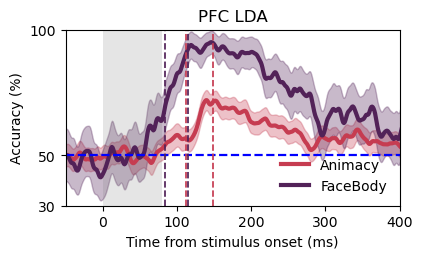

In [11]:
smooth_win = 2
plot_xlim = [-50,400]
plot_ylim = [30,100]
figure_size = np.array((4,2.5)) * 1
tmp_region = 'PFC'

m_plot([lda_anim_pfc,lda_fb_pfc], [color_anim,color_fb], error_method='std', 
       smooth_win=smooth_win, labels=['Animacy','FaceBody'], plot_title=f'{tmp_region} LDA', timepoints=time_stamps, figure_size=figure_size)

plt.axhline(chance_level, ls='--', c='b', lw=figure_size[0]*.4)

plt.axvline(np.nanmedian(onset_anim_pfc), ls='--', color=color_anim_n[:3], alpha=1, lw=figure_size[1]*.5)
plt.axvline(np.nanmedian(onset_fb_pfc), ls='--', color=color_fb_n[:3], alpha=1, lw=figure_size[1]*.5)

if 1:
       plt.axvline(np.nanmedian(peak_anim_pfc), ls='--', color=color_anim_n[:3], alpha=1, lw=figure_size[1]*.5)
       plt.axvline(np.nanmedian(peak_fb_pfc), ls='--', color=color_fb_n[:3], alpha=1, lw=figure_size[1]*.5)
else:
       plt.axvline(time_stamps[np.nanmean(lda_anim_pfc, axis=0).argmax()], ls='--', color=color_anim_n[:3], alpha=1, lw=figure_size[1]*.5)
       plt.axvline(time_stamps[np.nanmean(lda_fb_pfc, axis=0).argmax()], ls='--', color=color_fb_n[:3], alpha=1, lw=figure_size[1]*.5)

plt.xlabel('Time from stimulus onset (ms)')
plt.xlim(plot_xlim)
plt.xticks([0,100,200,300,400])

plt.ylabel('Accuracy (%)')
plt.ylim(plot_ylim)
plt.yticks([plot_ylim[0], chance_level, plot_ylim[1]])

clear_output()
# plt.savefig(f'{FigDir}lda_{tmp_region}_both.svg')

Onset ITC = 83.0 -+ 12.27363454144964
Onset PFC = 112.0 -+ 20.12078207855531
Onset Permutation p = 1.999960000799984e-05
Onset p (comp_means) = 0.0660434630890685
-----
Peak ITC = 115.0 -+ 19.702814980972978
Peak PFC = 149.0 -+ 20.81022158780756
Peak Permutation p = 1.999960000799984e-05
Peak p (comp_means) = 0.06861135808812335
-----
Solution ITC = 35.0 -+ 21.14338811545427
Solution PFC = 45.0 -+ 29.645786824057446
Solution Permutation p = 0.02233955320893582
Solution p (comp_means) = 0.7852664112567145


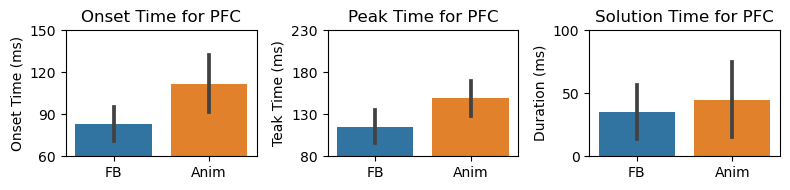

In [28]:
figure_size = np.array((8,2)) * 1
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=figure_size)
error_method = 'sd'
estimator = 'median'
xtick_labels = ["FB", "Anim"]

plt_onset = sns.barplot(ax=ax[0], data=[onset_fb_pfc, onset_anim_pfc], estimator='median', errorbar=error_method)
ax[0].set_ylim([60,150])
ax[0].set_yticks([60,90,120,150])
ax[0].set_ylabel('Onset Time (ms)')
ax[0].set_title(f'Onset Time for {tmp_region}')
plt_onset.set(xticklabels=xtick_labels)

plt_peak = sns.barplot(ax=ax[1], data=[peak_fb_pfc, peak_anim_pfc], estimator='median', errorbar=error_method)
ax[1].set_ylim([80,230])
ax[1].set_yticks([80,130,180,230])
ax[1].set_ylabel('Teak Time (ms)')
ax[1].set_title(f'Peak Time for {tmp_region}')
plt_peak.set(xticklabels=xtick_labels)

plt_sol = sns.barplot(ax=ax[2], data=[sol_fb_pfc, sol_anim_pfc], estimator='median', errorbar=error_method)
ax[2].set_ylim([0,100])
ax[2].set_yticks([0,50,100])
ax[2].set_ylabel('Duration (ms)')
ax[2].set_title(f'Solution Time for {tmp_region}')
plt_sol.set(xticklabels=xtick_labels)

plt.tight_layout()

print(f'Onset ITC = {np.nanmedian(onset_fb_pfc)} -+ {np.nanstd(onset_fb_pfc)}')
print(f'Onset PFC = {np.nanmedian(onset_anim_pfc)} -+ {np.nanstd(onset_anim_pfc)}')
print(f"Onset Permutation p = {comp_permute_p(onset_fb_pfc, onset_anim_pfc)}")
print(f"Onset p (comp_means) = {compare_means_bs(onset_fb_pfc, onset_anim_pfc)}")
print(f"-----")
print(f'Peak ITC = {np.nanmedian(peak_fb_pfc)} -+ {np.nanstd(peak_fb_pfc)}')
print(f'Peak PFC = {np.nanmedian(peak_anim_pfc)} -+ {np.nanstd(peak_anim_pfc)}')
print(f"Peak Permutation p = {comp_permute_p(peak_fb_pfc, peak_anim_pfc)}")
print(f"Peak p (comp_means) = {compare_means_bs(peak_fb_pfc, peak_anim_pfc)}")
print(f"-----")
print(f'Solution ITC = {np.nanmedian(sol_fb_pfc)} -+ {np.nanstd(sol_fb_pfc)}')
print(f'Solution PFC = {np.nanmedian(sol_anim_pfc)} -+ {np.nanstd(sol_anim_pfc)}')
print(f"Solution Permutation p = {comp_permute_p(sol_fb_pfc, sol_anim_pfc)}")
print(f"Solution p (comp_means) = {compare_means_bs(sol_fb_pfc, sol_anim_pfc)}")

# plt.savefig(f'{FigDir}lda_{tmp_region}_stat_both.svg')